Score and explain a `drafttopic` prediction.

Requires the "drafttopic" repository is checked out under your home directory.

In [1]:
import os.path

from revscoring import Model


model_path = os.path.expanduser("~/drafttopic/models/enwiki.drafttopic.gradient_boosting.model")
sm = Model.load(open(model_path), error_on_env_check=False)

/home/awight/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Differences between the current environment and the environment in which the model was constructed environment were detected:
 - revscoring_version '2.2.3' mismatch with original environment '2.2.5'
 - platform 'Linux-4.9.0-5-amd64-x86_64-with-debian-9.4' mismatch with original environment 'Linux-4.16.0-x86_64-with-debian-9.4'
 - version '#1 SMP Debian 4.9.65-3+deb9u2 (2018-01-04)' mismatch with original environment '#1 SMP Wed Apr 18 14:02:11 PDT 2018'
 - release '4.9.0-5-amd64' mismatch with original environment '4.16.0'


In [2]:
import mwapi
from revscoring.extractors import api

extractor = api.Extractor(mwapi.Session("https://en.wikipedia.org", user_agent="ORES-LIME demo"))

Pick a revision, extract the features and score.

In [3]:
import numpy as np
from revscoring.datasources import revision_oriented

# Initial revision for "Zatrachydidae"
rev_to_score = 44346279

original_text = list(extractor.extract(rev_to_score, [revision_oriented.revision.text]))[0]
original_text

"{{Taxobox\n| color = pink\n| name = Zatracheidae\n| regnum = [[Animal]]ia\n| phylum = [[Chordate|Chordata]]\n| superclassis = [[Tetrapoda]]\n| classis = [[Amphibia]]\n| ordo = [[Temnospondyli]]\n| subordo = [[Euskelia]]\n| superfamilia = [[Eryopoidea]]\n| familia = Zatracheidae\n| familia_authority = [[Samuel Wendall Williston|Williston]], [[1910]]\n| subdivision_ranks = Genera\n| subdivision = \n''Dasyceps''<br>\n''Stegops''<br>\n''[[Zatrachys]]'' \n}}\n'''Zatracheidae''' are a family of [[Pennsylvanian|late Carboniferous]] and Early [[Permian]] [[temnospondyli]] amphibians, known from North America and Europe.   They are defined by lateral (sideways) bony protuberances of the [[quadratojugual]], and a large opening in the palate.  The skull is flattened, with small [[orbit (skull)|orbits]] set far back.  The opening may have housed a [[gland]] for producing a sticky substance so that prey adhere to the tongue.  If so, this indicates that these animals spent a large part of their tim

In [4]:
features = [str(f) for f in sm.features]
feature_values = np.array(list(extractor.extract(rev_to_score, sm.features)))

print("https://en.wikipedia.org/?diff={}".format(rev_to_score))
sm.score(feature_values)

https://en.wikipedia.org/?diff=44346279


{'prediction': [],
 'probability': {'Assistance.Article improvement and grading': 1.4722961877979616e-05,
  'Assistance.Contents systems': 0.012070583726032319,
  'Assistance.Files': 0.0007479148740839336,
  'Assistance.Maintenance': 0.03319381973291589,
  'Culture.Arts': 0.00043306434637992565,
  'Culture.Broadcasting': 0.001914745418360013,
  'Culture.Crafts and hobbies': 0.0052501066308790955,
  'Culture.Entertainment': 0.0032534064126115143,
  'Culture.Food and drink': 0.004508562882747073,
  'Culture.Internet culture': 0.0005174152040251448,
  'Culture.Language and literature': 0.19639413319672244,
  'Culture.Media': 0.00238170442580509,
  'Culture.Performing arts': 0.0007806989976713559,
  'Culture.Philosophy and religion': 0.009736713698132352,
  'Culture.Plastic arts': 0.004785199726301465,
  'Culture.Sports': 0.0017534756476867072,
  'Culture.Visual arts': 0.013635710406283526,
  'Geography.Bodies of water': 0.001782348245622655,
  'Geography.Cities': 0.0006671180773200715,
  

Set up a LIME explainer for this model.  It will perturb the text content of the revision being scored.

In [5]:
from lime.lime_text import LimeTextExplainer

class_names = sm.info["params"]["labels"]

def score(text):
    cache = {"datasource.revision.text": text}
    feature_values = np.array(list(extractor.extract(rev_to_score, sm.features, cache=cache)))
    probabilities = sm.score(feature_values)["probability"]
    return np.array([probabilities[k] for k in class_names])

def score_all(samples):
    raw_results = [score(v) for v in samples]
    return np.array(raw_results)

explainer = LimeTextExplainer(
    class_names=class_names
)

Calculate the explanation for this prediction.  Note: this may take 5 minutes or longer.

In [6]:
exp = explainer.explain_instance(
    original_text,
    score_all,
    num_features=20,
    top_labels=3
)


/home/awight/venv/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


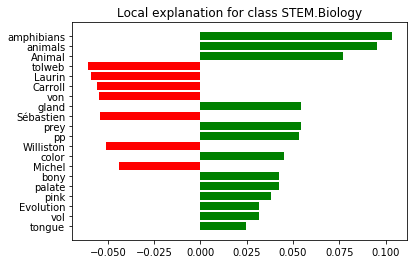

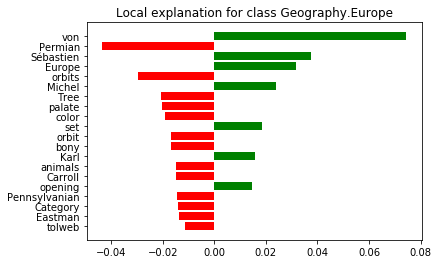

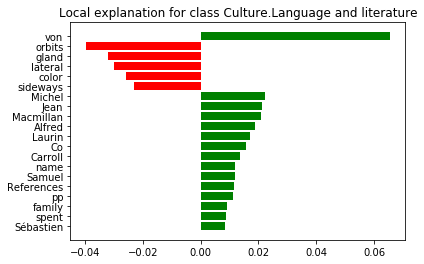

In [7]:
%matplotlib inline
for label_index in exp.local_exp.keys():
    fig = exp.as_pyplot_figure(label=label_index)